## 📈Proyecto 1: Análisis Cuantitativo de Cartera de Inversión (Python)

Este proyecto aplica técnicas de ciencia de datos para evaluar el riesgo y el rendimiento de una cartera de activos, simulando un análisis de Gestión de Activos en el sector bancario.

In [30]:
import yfinance as yf
import pandas as pd 
import numpy as np 

## 🔍 Ingesta, Limpieza y Transformación de Datos

En esta sección, se define la fuente de datos (Yahoo Finance) y se extraen los precios históricos. El paso más crítico es la transformación de precios a rendimientos logarítmicos, que son la base para el modelado de riesgo.


### 1.1 Definición de la Cartera y Recolección de precios
La cartera de prueba se compone de cuatro activos que representan distintos perfiles de riesgo en el mercado:

In [34]:
# Tickers de la cartera y el benchmark (Usamos PG)
TICKERS = ['AAPL', 'JPM', 'PG', 'SPY']
PERIODO = '5y' 

# 1. Descarga de datos: Descargamos todas las columnas.
# Eliminamos la variable datos_precios y el error de selección
datos_completos = yf.download(TICKERS, period=PERIODO)

# SOLUCIÓN CRÍTICA: IMPRIMIR LOS NOMBRES DE COLUMNA PARA DIAGNÓSTICO
print("--- NOMBRES DE COLUMNA PARA DIAGNÓSTICO ---")
print(datos_completos.columns.get_level_values(0).unique())

/var/folders/cv/2xdxtdpd295g4qndlgwlpl040000gn/T/ipykernel_91050/2270360370.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  datos_completos = yf.download(TICKERS, period=PERIODO)
[*********************100%***********************]  4 of 4 completed

--- NOMBRES DE COLUMNA PARA DIAGNÓSTICO ---
Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')


In [35]:
# Seleccion de los precios 
datos_precios = datos_completos.xs(key='Close', axis = 1, level = 0)

# Limpiamos un poco los datos eliminando los Null values 
datos_precios = datos_precios.dropna()

# Verificamos que todo este en orden
print("Primeras 5 filas de los precios de cierre : ")
print(datos_precios.head())

Primeras 5 filas de los precios de cierre : 
Ticker            AAPL         JPM          PG         SPY
Date                                                      
2020-12-07  120.464714  107.044014  121.489960  344.088165
2020-12-08  121.077995  107.149399  121.816444  345.094971
2020-12-09  118.547005  106.315048  120.369301  341.999847
2020-12-10  119.968254  105.629974  119.575127  341.888031
2020-12-11  119.160309  105.006409  120.457535  341.487061


### 1.2 Transformación a rendiientos logaritimicos 

Utilizamos rendimientos logarítmicos para el análisis de riesgo, ya que son aditivos y se ajustan mejor a la distribución normal que se asume en los modelos de volatilidad. Esta transformación es clave para la precisión del modelo.

In [33]:
# Rendimientos logaritimicos diarios    rendimiento = log(precio hoy / precio ayer)
rendimientos = np.log(datos_precios/datos_precios.shift(1)).dropna()

# Verificamos los rendimientos 
print('\nPrimeras 5 filas de los rendimientos diarios (logaritimicos) : ')
print(rendimientos.head())


Primeras 5 filas de los rendimientos diarios (logaritimicos) : 
Ticker          AAPL       JPM        PG       SPY
Date                                              
2020-12-08  0.005078  0.000984  0.002684  0.002922
2020-12-09 -0.021125 -0.007817 -0.011951 -0.009009
2020-12-10  0.011917 -0.006465 -0.006620 -0.000327
2020-12-11 -0.006758 -0.005921  0.007353 -0.001173
2020-12-14 -0.005160 -0.010595 -0.004847 -0.004487


### ✅ Resultado: 

Los datos han sido transformados exitosamente de precios absolutos a rendimientos logarítmicos diarios. La limpieza de datos (dropna()) asegura que la matriz de datos esté completa y sincronizada para todos los activos a lo largo de los 5 años, un requisito fundamental para el cálculo de la covarianza.






## 📊 2. Análisis de riesgo y retorno (volatilidad y matriz de covarianza)

En esta fase, convertimos los rendimientos diarios en métricas anualizadas de riesgo (Volatilidad) y examinamos cómo se mueven los activos entre sí (Covarianza). Esta es la base para entender la diversificación.

### 2.1. Cálculo de Rendimiento y Volatilidad Anualizados

Para comparar el rendimiento y el riesgo con métricas comunes de mercado, anualizamos los valores diarios (multiplicamos por $\sqrt{252}$ para el riesgo y por $252$ para el rendimiento, asumiendo 252 días de trading al año).

In [39]:
# Frecuencia de trading 
dias_trading_anual = 252 

# Rendimiento promedio anualizado.      media x 252
rendimiento_anual = rendimientos.mean() * dias_trading_anual


# Volatilitad analizada (RIESGO).          std() x sqrt(252)
volatilidad_anualizada = rendimientos.std() * np.sqrt(dias_trading_anual)


# RESUMEN EJECUTIVO 
resumen_riesgo_retorno = pd.DataFrame({
    'Rendimiento Anual (%)' : rendimiento_anual * 100,
    'Volatilidad Anual (%)' : volatilidad_anualizada * 100
}).sort_values(by = 'Volatilidad Anual (%)', ascending = False)

print("Resumenn de Rendimiento vs Riesgo : ")
print(resumen_riesgo_retorno)


Resumenn de Rendimiento vs Riesgo : 
        Rendimiento Anual (%)  Volatilidad Anual (%)
Ticker                                              
AAPL                16.848175              27.966491
JPM                 21.675207              24.169608
PG                   3.336339              17.207817
SPY                 13.845500              17.081302


## 2.2 Matriz de correlacion (Base de la diversificación)

La correlación indica qué tan similar es el movimiento de los activos (entre $-1$ y $+1$). En la banca, **buscamos baja correlación** para lograr una cartera diversificada y reducir el riesgo.


Matriz de correlacion de activos: 
Ticker      AAPL       JPM        PG       SPY
Ticker                                        
AAPL    1.000000  0.347029  0.248024  0.756722
JPM     0.347029  1.000000  0.190930  0.624451
PG      0.248024  0.190930  1.000000  0.319769
SPY     0.756722  0.624451  0.319769  1.000000


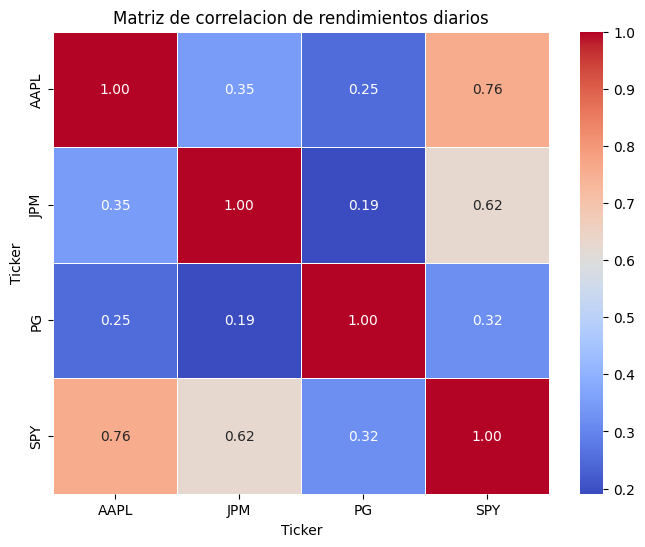

In [42]:
# Calculamos la matriz de correlación
matriz_correlacion = rendimientos.corr()

print('Matriz de correlacion de activos: ')
print(matriz_correlacion)

#Visualizamos la correlacion

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (8,6))
sns.heatmap(matriz_correlacion, annot = True, cmap = 'coolwarm' , fmt = '.2f', linewidths = .5)
plt.title('Matriz de correlacion de rendimientos diarios')
plt.show()